In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

seed = 12345
rng = np.random.default_rng(seed)  # can be called without a seed
rng.random()

df = pd.read_csv (r"C:\Users\White\Desktop\tfg\generados\dft.csv")


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336090 entries, 0 to 336089
Data columns (total 62 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Src Port            336090 non-null  int64  
 1   Dst Port            336090 non-null  int64  
 2   Tot Fwd Pkts        336090 non-null  int64  
 3   Fwd Pkt Len Min     336090 non-null  int64  
 4   Fwd Pkt Len Mean    336090 non-null  float64
 5   Bwd Pkt Len Max     336090 non-null  int64  
 6   Bwd Pkt Len Min     336090 non-null  int64  
 7   Flow Byts/s         336090 non-null  float64
 8   Flow IAT Mean       336090 non-null  float64
 9   Flow IAT Min        336090 non-null  float64
 10  Fwd IAT Tot         336090 non-null  float64
 11  Fwd IAT Mean        336090 non-null  float64
 12  Fwd IAT Max         336090 non-null  float64
 13  Fwd IAT Min         336090 non-null  float64
 14  Bwd IAT Tot         336090 non-null  float64
 15  Bwd IAT Mean        336090 non-nul

In [3]:
# Isolation Forest ----
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest


X = df.copy()
y = X.pop("LabelA")
# training the model
clf = IsolationForest(n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.01,
                n_jobs        = -1,
                random_state  = 123)


In [4]:
clf.fit(X)

IsolationForest(contamination=0.01, n_estimators=1000, n_jobs=-1,
                random_state=123)

In [5]:
score_anomalia = clf.score_samples(X)

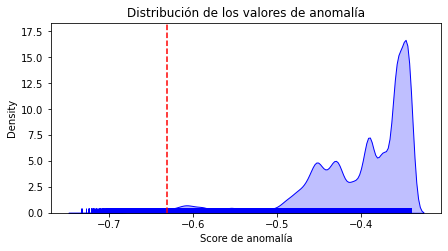

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.distplot(
    score_anomalia,
    hist    = False,
    rug     = True,
    color   = 'blue',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax
)

ax.axvline(clf.offset_, c='red', linestyle='--', label='cuantil 0.01')
ax.set_title('Distribución de los valores de anomalía')
ax.set_xlabel('Score de anomalía');

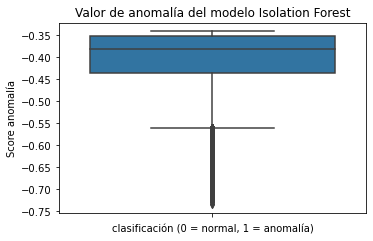

In [7]:
# Distribución de los valores de anomalía
# ==============================================================================
df_resultados = pd.DataFrame({
                    'score'    : score_anomalia,
                })

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 3.5))
sns.boxplot(
    y     = 'score',
    data  = df_resultados,
    #color = "white",
    palette = 'tab10',
    ax    = ax
)

ax.set_title('Valor de anomalía del modelo Isolation Forest')
ax.set_ylabel('Score anomalía')
ax.set_xlabel('clasificación (0 = normal, 1 = anomalía)');

In [8]:
# Matriz de confusión de la clasificación final
# ==============================================================================
df_resultados = df_resultados \
                .sort_values('score', ascending=True) \
                .reset_index(drop=True)

#df_resultados['clasificacion'] = np.where(df_resultados.index <= 176, 1, 0)


In [9]:
df['clasificacion'] = np.where(df_resultados['score']<-0.65,1,0)


In [10]:
dft=pd.concat([df, df_resultados], axis=1)
dfOutliers=dft[dft["clasificacion"]==1]
dfOutliers.info
dfOutliersDe=dft[dft["clasificacion"]==0]


In [11]:
dfOutliers["LabelA"].value_counts()

1    1710
Name: LabelA, dtype: int64

In [12]:
dfOutliers.to_csv(r"C:\Users\White\Desktop\tfg\generados\outliers.csv", index = None, header=True) 


In [13]:
dfOutliersDe.to_csv(r"C:\Users\White\Desktop\tfg\generados\Deoutliers.csv", index = None, header=True) 


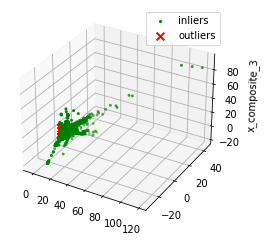

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

outlier_index=list(dfOutliers.index)

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(df)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

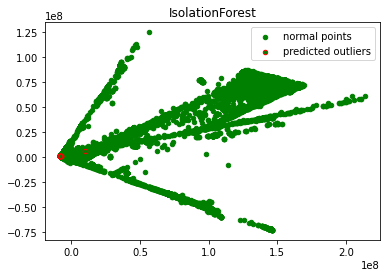

In [17]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(df)
res=pd.DataFrame(pca.transform(df))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [18]:
from scipy import stats
dfOutliersZ=df.copy()
dfOutliersZ=dfOutliersZ[(np.abs(stats.zscore(dfOutliersZ)) < 3).all(axis=1)]

In [19]:
dfOutliersZ.info()
dfOutliersZ["LabelA"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197419 entries, 1710 to 335900
Data columns (total 63 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Src Port            197419 non-null  int64  
 1   Dst Port            197419 non-null  int64  
 2   Tot Fwd Pkts        197419 non-null  int64  
 3   Fwd Pkt Len Min     197419 non-null  int64  
 4   Fwd Pkt Len Mean    197419 non-null  float64
 5   Bwd Pkt Len Max     197419 non-null  int64  
 6   Bwd Pkt Len Min     197419 non-null  int64  
 7   Flow Byts/s         197419 non-null  float64
 8   Flow IAT Mean       197419 non-null  float64
 9   Flow IAT Min        197419 non-null  float64
 10  Fwd IAT Tot         197419 non-null  float64
 11  Fwd IAT Mean        197419 non-null  float64
 12  Fwd IAT Max         197419 non-null  float64
 13  Fwd IAT Min         197419 non-null  float64
 14  Bwd IAT Tot         197419 non-null  float64
 15  Bwd IAT Mean        197419 non-

1    196727
0       692
Name: LabelA, dtype: int64

In [20]:
dfOutliersZ.to_csv(r"C:\Users\White\Desktop\tfg\generados\outliersZ.csv", index = None, header=True) 


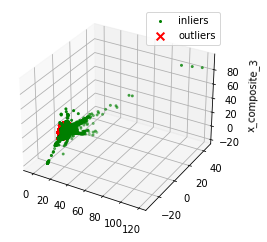

In [21]:
from sklearn.decomposition import PCA
outlier_index=list(dfOutliersZ.index)

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(df)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [22]:
stepframe=df.copy()

Q1 = stepframe.quantile(0.1)
Q3 = stepframe.quantile(0.75)
IQR = Q3 - Q1

dfOutIQR = stepframe[~((stepframe < (Q1 - 1.5 * IQR)) |(stepframe > (Q3 + 1.5 * IQR))).any(axis=1)]


In [23]:
dfOutIQR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75563 entries, 1710 to 246895
Data columns (total 63 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Src Port            75563 non-null  int64  
 1   Dst Port            75563 non-null  int64  
 2   Tot Fwd Pkts        75563 non-null  int64  
 3   Fwd Pkt Len Min     75563 non-null  int64  
 4   Fwd Pkt Len Mean    75563 non-null  float64
 5   Bwd Pkt Len Max     75563 non-null  int64  
 6   Bwd Pkt Len Min     75563 non-null  int64  
 7   Flow Byts/s         75563 non-null  float64
 8   Flow IAT Mean       75563 non-null  float64
 9   Flow IAT Min        75563 non-null  float64
 10  Fwd IAT Tot         75563 non-null  float64
 11  Fwd IAT Mean        75563 non-null  float64
 12  Fwd IAT Max         75563 non-null  float64
 13  Fwd IAT Min         75563 non-null  float64
 14  Bwd IAT Tot         75563 non-null  float64
 15  Bwd IAT Mean        75563 non-null  float64
 16  

In [24]:
dfIQR=df.copy()


Q1 = dfIQR.quantile(0.01)
Q3 = dfIQR.quantile(0.9999)
IQR = Q3 - Q1

#Values between Q1-1.5IQR and Q3+1.5IQR
filtered = dfIQR[~((dfIQR < (Q1 - 1.5 * IQR)) |(dfIQR > (Q3 + 1.5 * IQR))).any(axis=1)]



In [25]:
elimin = dfIQR[((dfIQR < (Q1 - 1.5 * IQR)) |(dfIQR > (Q3 + 1.5 * IQR))).any(axis=1)]


In [26]:
elimin["LabelA"].value_counts()

0    48
1    11
Name: LabelA, dtype: int64

In [27]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336031 entries, 0 to 336089
Data columns (total 63 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Src Port            336031 non-null  int64  
 1   Dst Port            336031 non-null  int64  
 2   Tot Fwd Pkts        336031 non-null  int64  
 3   Fwd Pkt Len Min     336031 non-null  int64  
 4   Fwd Pkt Len Mean    336031 non-null  float64
 5   Bwd Pkt Len Max     336031 non-null  int64  
 6   Bwd Pkt Len Min     336031 non-null  int64  
 7   Flow Byts/s         336031 non-null  float64
 8   Flow IAT Mean       336031 non-null  float64
 9   Flow IAT Min        336031 non-null  float64
 10  Fwd IAT Tot         336031 non-null  float64
 11  Fwd IAT Mean        336031 non-null  float64
 12  Fwd IAT Max         336031 non-null  float64
 13  Fwd IAT Min         336031 non-null  float64
 14  Bwd IAT Tot         336031 non-null  float64
 15  Bwd IAT Mean        336031 non-nul

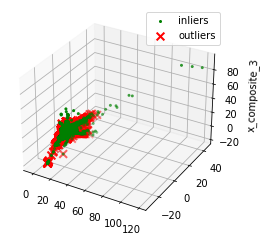

In [28]:


##Plot##################

from sklearn.decomposition import PCA
outlier_index=list(filtered.index)

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(dfIQR)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

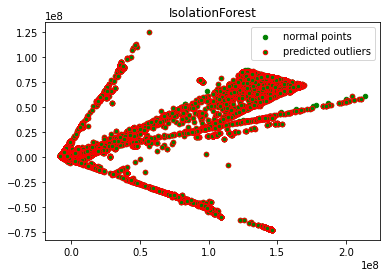

In [29]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(dfIQR)
res=pd.DataFrame(pca.transform(dfIQR))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [30]:
# initial plot
df1 = df.copy()
dfInit=df1.shape[0]
print(df1.shape[0])

# Function to identify and remove outliers
def outliers(df, level):

    # 1. temporary dataframe
    dft = df1.copy(deep = True)

    # 2. Select a level for a Z-score to identify and remove outliers
    df_Z = dft[(np.abs(stats.zscore(dft)) < level).all(axis=1)]
    ix_keep = df_Z.index

    # 3. Subset the raw dataframe with the indexes you'd like to keep
    df_keep = df.loc[ix_keep]

    return(df_keep)

# remove outliers
level = 5
print("level = " + str(level))
df_clean = outliers(df = df1, level = level)
noutliers=df1.shape[0]-df_clean.shape[0]
# final plot
print("Removed " + str(noutliers) +" Outliers")

336090
level = 5
Removed 43132 Outliers


In [31]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))


NameError: name 'sklearn' is not defined